<h1>Markowitz Portfolio Optimization Using Python</h1>


In [1]:
import numpy as np
import pandas as pd

In [2]:
df_stocks = pd.read_csv('portfolio_data.csv').set_index('Date')
df_stocks.index = pd.to_datetime(df_stocks.index)

In [3]:
# Portfolio Actual Returns
portfolio_returns1 = (df_stocks/df_stocks.shift(1)).dropna()
returns_df = np.log(portfolio_returns1).dropna()

In [4]:
returns_df.head()

,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-02,0.017254,0.015436,-0.079807,0.007394
2013-05-03,0.021544,0.008792,0.140515,-0.004860
2013-05-06,-0.009070,0.014366,-0.029665,-0.013015
2013-05-07,0.007829,0.017629,0.032319,-0.021299
2013-05-08,0.003679,0.004316,-0.003540,0.011377


In [5]:
simple_returns = np.exp(returns_df) -1

In [6]:
simple_returns

,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-02,0.017403,0.015556,-0.076706,0.007421
2013-05-03,0.021778,0.008830,0.150867,-0.004849
2013-05-06,-0.009029,0.014469,-0.029229,-0.012930
2013-05-07,0.007860,0.017785,0.032847,-0.021074
2013-05-08,0.003686,0.004325,-0.003534,0.011442
...,...,...,...,...
2019-05-08,-0.001681,0.020765,0.028881,-0.016439
2019-05-09,-0.009334,-0.003496,0.030190,-0.004446
2019-05-10,-0.005206,-0.013432,0.131021,-0.004714


# Basic EDA

We will visualize the asset correlation, returns series, annualized volatility, and annualized Sharpe Ratio for each stock. <br>
Note that we will use **252 trading days a year** for our calculations, which is the convention adopted for US portfolios. 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
round(returns_df.corr(), 2)

,AMZN,DPZ,BTC,NFLX
AMZN,1.00,0.31,-0.01,0.45
DPZ,0.31,1.00,-0.01,0.25
BTC,-0.01,-0.01,1.00,0.01
NFLX,0.45,0.25,0.01,1.00


## Asset Correlation

Text(0.5, 1.0, 'Asset Correlations')

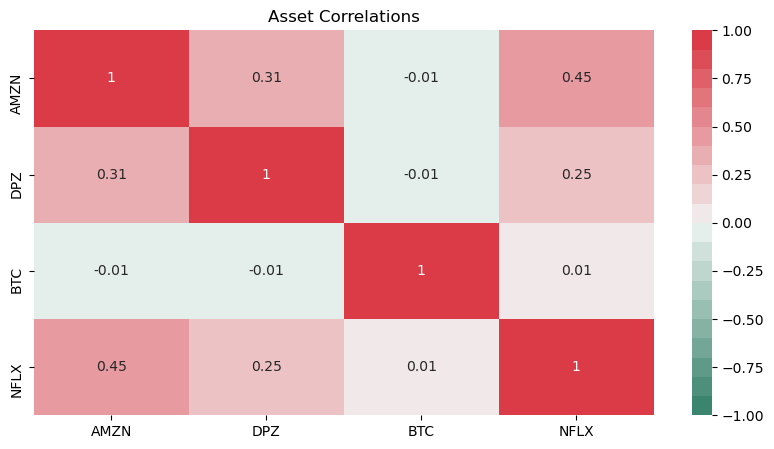

In [9]:
plt.figure(figsize=(10, 5))
sns.heatmap(round(returns_df.corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Correlations")

## Cumulative Returns

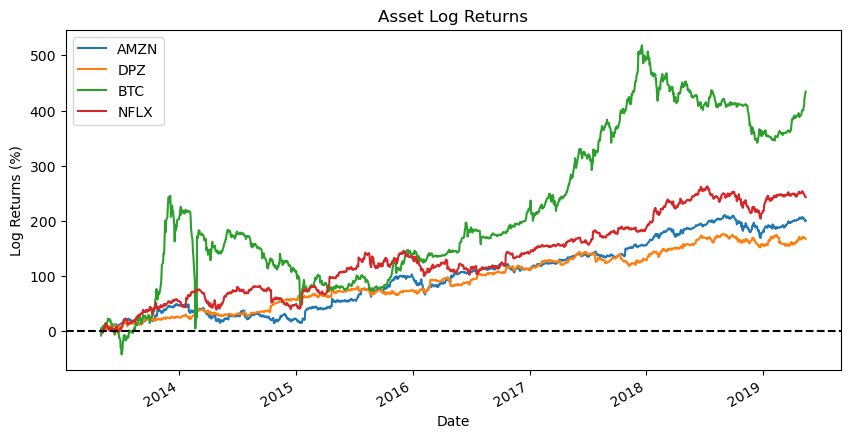

In [10]:
# convert returns to % and plot the returns series for all stocks
returns_df.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (10, 5))
plt.title("Asset Log Returns")
plt.ylabel("Log Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

## Annualized Volatility

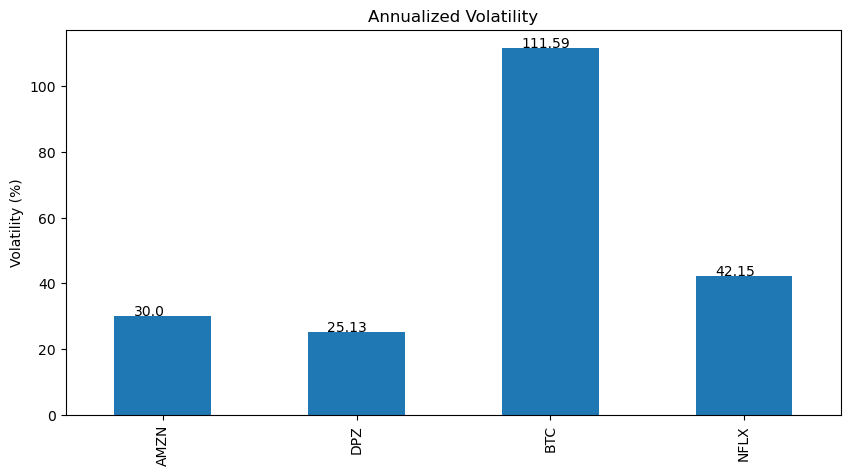

In [11]:
# calculate annualized volatility (standard deviation * sqrt(252)), expressed in %
ax = round(returns_df.std() * 252 ** 0.5 * 100, 2).plot(figsize = (10, 5), kind = "bar")
plt.title("Annualized Volatility")
plt.ylabel("Volatility (%)")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height() + 0.2))

## Annualized Sharpe Ratio

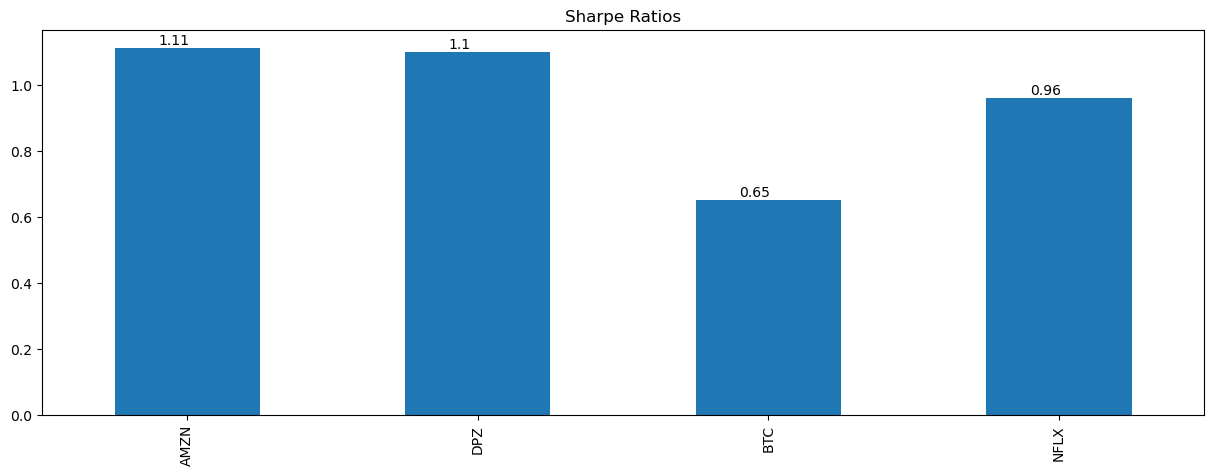

In [12]:
# calculate Sharpe Ratio, and annualize it by multiplying sqrt(252)
ax = round(returns_df.mean(axis = 0) / returns_df.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))

plt.title("Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

# Portfolio Optimization

In [13]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [14]:
simple_returns

,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-02,0.017403,0.015556,-0.076706,0.007421
2013-05-03,0.021778,0.008830,0.150867,-0.004849
2013-05-06,-0.009029,0.014469,-0.029229,-0.012930
2013-05-07,0.007860,0.017785,0.032847,-0.021074
2013-05-08,0.003686,0.004325,-0.003534,0.011442
...,...,...,...,...
2019-05-08,-0.001681,0.020765,0.028881,-0.016439
2019-05-09,-0.009334,-0.003496,0.030190,-0.004446
2019-05-10,-0.005206,-0.013432,0.131021,-0.004714


In [15]:
# define in-sample period (for optimization) and out-of-sample period (for evaluation)
in_sample = "2018-04-30"
is_returns_df = simple_returns.loc[:in_sample]
oos_returns_df = simple_returns.loc[in_sample:][1:] # one day after in_sample date

In [16]:
# Calculate expected returns and sample covariance using PyPortfolioOpt’s built-in methods
# mu = expected_returns.mean_historical_return(is_returns_df, returns_data=True)
mu = expected_returns.capm_return(is_returns_df, returns_data=True)
S = risk_models.sample_cov(is_returns_df, returns_data=True)

print('Expected Returns:')
print(mu)
print('\n')
print('Covariance Matrix:')
print(S)

Expected Returns:
AMZN    0.167493
DPZ     0.134208
BTC     3.270256
NFLX    0.266249
Name: mkt, dtype: float64


Covariance Matrix:
          AMZN       DPZ       BTC      NFLX
AMZN  0.085428  0.020467 -0.005370  0.046698
DPZ   0.020467  0.058930  0.010791  0.023811
BTC  -0.005370  0.010791  3.242897 -0.003976
NFLX  0.046698  0.023811 -0.003976  0.179269


### Maximize Sharpe Ratio

In [17]:
from pypfopt import plotting

In [18]:
# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_max_sharpe = ef.max_sharpe()

# Output portfolio performance
ef.portfolio_performance(verbose=True) # return, vol, sharpe

optimal_weights_portfolio_max_sharpe = np.array(list(optimal_weights_portfolio_max_sharpe.values()))
round(pd.Series(optimal_weights_portfolio_max_sharpe, index = is_returns_df.columns), 2)

Expected annual return: 96.0%
Annual volatility: 48.4%
Sharpe Ratio: 1.94


AMZN    0.25
DPZ     0.25
BTC     0.25
NFLX    0.25
dtype: float64

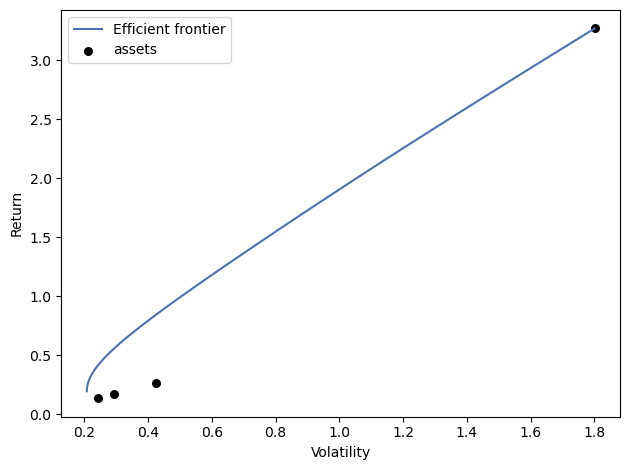

In [19]:
# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

### Minimize Risk Given Returns Limit

Fix annual returns at a specified level (15.0%) and minimise volatility.

In [20]:
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_eff_returns = ef.efficient_return(0.15)
ef.portfolio_performance(verbose=True)

optimal_weights_portfolio_eff_returns = np.array(list(optimal_weights_portfolio_eff_returns.values()))
round(pd.Series(optimal_weights_portfolio_eff_returns, index = is_returns_df.columns), 2)

Expected annual return: 19.3%
Annual volatility: 20.8%
Sharpe Ratio: 0.83


AMZN    0.32
DPZ     0.59
BTC     0.01
NFLX    0.08
dtype: float64

### Maximize Returns Given Risk Limit

In [21]:
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_eff_risk = ef.efficient_risk(0.25)
ef.portfolio_performance(verbose=True) # return, vol, sharpe

optimal_weights_portfolio_eff_risk = np.array(list(optimal_weights_portfolio_eff_risk.values()))
round(pd.Series(optimal_weights_portfolio_eff_risk, index = is_returns_df.columns), 2)

Expected annual return: 43.7%
Annual volatility: 25.0%
Sharpe Ratio: 1.67


AMZN    0.30
DPZ     0.48
BTC     0.09
NFLX    0.13
dtype: float64